# 2.3 - GOES16 - Reprojections

In [1]:
import autoroot
import os
from dotenv import load_dotenv
from pathlib import Path
import earthaccess
import numpy as np
import rioxarray
import xarray as xr
from dataclasses import dataclass
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

# PLOTTING
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import rasterio
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import seaborn as sns
sns.reset_defaults()
sns.set_context(context="talk", font_scale=0.7)



xr.set_options(
    keep_attrs=True, 
    display_expand_data=False, 
    display_expand_coords=False, 
    display_expand_data_vars=False, 
    display_expand_indexes=False
)
np.set_printoptions(threshold=10, edgeitems=2)

%load_ext autoreload
%autoreload 2

### Download GOES16

GOES16 is a geostationary satellite so there are very frequent observations.
The data is typically stored as full fields so we need to be smart when selecting the datasets.
For this example, we will only download the data that is available from the MODIS satellite.

In [2]:
from rs_tools._src.data.modis import MODISFileName, MODIS_ID_TO_NAME, MODIS_NAME_TO_ID
from rs_tools._src.utils.io import get_list_filenames
import pandas as pd

/home/juanjohn/miniconda/envs/rs_tools/lib/python3.11/site-packages/goes2go/data.py:519: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  within=pd.to_timedelta(config["nearesttime"].get("within", "1H")),
/home/juanjohn/miniconda/envs/rs_tools/lib/python3.11/site-packages/goes2go/NEW.py:188: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  within=pd.to_timedelta(config["nearesttime"].get("within", "1H")),


In [3]:
# environment variables
save_dir = Path(os.getenv("ITI_DATA_SAVEDIR"))
goes_read_dir = Path("/pool/usuarios/juanjohn/data/iti/pipeline_test/goes16/raw")
goes_save_dir = Path("/pool/usuarios/juanjohn/data/iti/pipeline_test/goes16/clean")
goes_read_dir.mkdir(parents=True, exist_ok=True)
goes_save_dir.mkdir(parents=True, exist_ok=True)
goes_read_dir

PosixPath('/pool/usuarios/juanjohn/data/iti/pipeline_test/goes16/raw')

We will subset each of them to extract the timestamps when they were retrieved.

In [4]:
# list of all .hdf files in the directory
all_goes_files = get_list_filenames(goes_read_dir, ".nc")

len(all_goes_files)

144

In [5]:
all_goes_files[1]

'/pool/usuarios/juanjohn/data/iti/pipeline_test/goes16/raw/noaa-goes16/ABI-L1b-RadF/2020/275/15/OR_ABI-L1b-RadF-M6C02_G16_s20202751500196_e20202751509504_c20202751509548.nc'

#### Sort Files

In [6]:
from rs_tools.goes import preprocess_goes16_radiance_band, clean_coords_goes16
from rs_tools.goes import parse_goes16_dates_from_file, GOES16_CHANNELS

First, we need to sort the files according to some sort of criteria.
The GOES16 files are saved with a lot of meta-data in the names so it makes it quite easy to filter them.
A simple way to figure out the bands and files is to find all of the unique time stamps.
Then we can filter for the time that we are interested in to get a stack of GOES images.

In [7]:
# get unique times
unique_times = list(set(map(parse_goes16_dates_from_file, all_goes_files)))

# filter files for unique times
demo_time = unique_times[0]
set_goes_files = list(filter(lambda x: demo_time in x, all_goes_files))

assert len(set_goes_files) == 16

* resample resolution, `1,000`
* clean attributes
* choose area, region or bounding box

### Preprocess a Single File

We have an automated routine to preprocess the GOES16 file.

In [8]:
from rs_tools._src.geoprocessing.goes.geoprocessor_goes16_refactor import geoprocess_goes16_file

In [9]:
ds = geoprocess_goes16_file(
    set_goes_files,
    resolution=10_000, 
    geometry=None,
)

  0%|                                                                                                                                                                                                                                   | 0/16 [00:00<?, ?it/s]/home/juanjohn/miniconda/envs/rs_tools/lib/python3.11/site-packages/xarray/backends/plugins.py:80: RuntimeWarning: Engine 'gini' loading failed:
module 'numpy' has no attribute 'cumproduct'
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)
Loading Radiance file 16/16: OR_ABI-L1b-RadF-M6C16_G16_s20202751820193_e20202751829513_c20202751829574.nc: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:38<00:00,  2.39s/it]


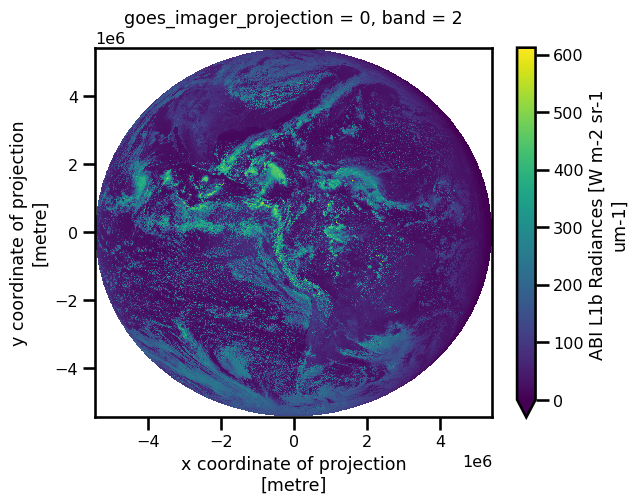

In [10]:
ds.radiance.isel(band=1).plot(cmap="viridis", vmin=0.0)

## Reprojection

### Method I - Choosing a Destination

In [11]:
%%time
from odc.geo.crs import CRS

dst_crs = CRS("EPSG:4326")
dst_resolution = 0.25
ds_goes_reproject = ds.rio.reproject(dst_crs=dst_crs, resolution=dst_resolution)

CPU times: user 227 ms, sys: 132 ms, total: 358 ms
Wall time: 361 ms


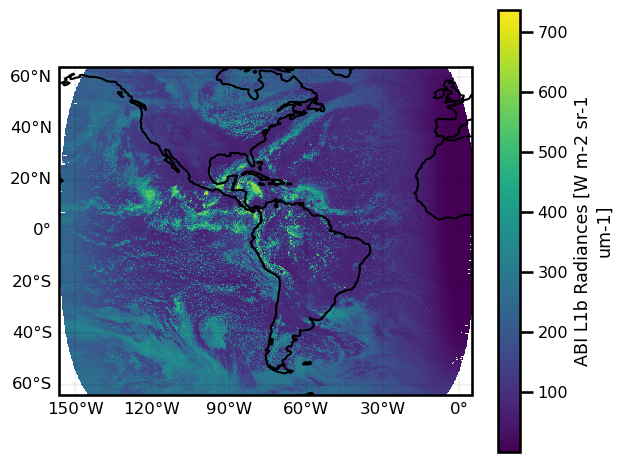

In [12]:
# in an even better way 
fig = plt.figure()
ax = plt.axes(projection=ccrs.PlateCarree())

ds_goes_reproject.radiance.isel(band=0).plot(
    ax=ax,
    x="x", y="y", 
    transform=ccrs.PlateCarree(),
)

ax.set(
    title=""
)
ax.coastlines()

# Plot lat/lon grid 
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=0.1, color='k', alpha=1, 
                  linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 12}
gl.ylabel_style = {'size': 12} 
plt.tight_layout()
plt.show()

### Method II - Clipping

These images are quite large, especially bands 2 and 3.
So we offer the users a way to geoprocess the images with some clipping and rescaling.
This is useful if we also want to look for cross-over satellite images, e.g., GOES & MODIS.

#### ROI

First, we need a region of interest (ROI).
There are multiple ways to do this.
However, in the `rs_tools` package, we will be using the `GeoBox` because it offers the most complete set of features that we will need without having to use different packages.
How you construct your geobox is up to you, but the resulting data structure is what will be used throughout this package.

In [16]:
from odc.geo.geom import BoundingBox, Geometry
from odc.geo.geobox import GeoBox

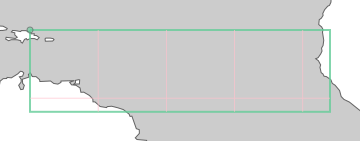

In [17]:
# create a bounding box from xy
lon_bnds = [-70, -15]
lat_bnds = [20, 5]
bbox = BoundingBox.from_xy(x=lon_bnds, y=lat_bnds, crs="4326")

# initialize geobox
resolution = 0.25 # degrees
gbox = GeoBox.from_bbox(bbox, resolution=resolution, crs="4326")

gbox

Probably the best feature is that you can see the resulting box to check if what you did makes sense.

#### Geometry Clipping

To be able to reproject to a different setting, we need the following information:
* CRS
* geometries

In [19]:
%%time
# parameters
dst_crs = gbox.boundingbox.crs
geometries = [gbox.boundingbox.polygon]

# perform reprojection
ds_goes_reproject = ds.rio.clip(geometries=geometries, crs=dst_crs)

CPU times: user 148 ms, sys: 1.51 s, total: 1.65 s
Wall time: 1.78 s


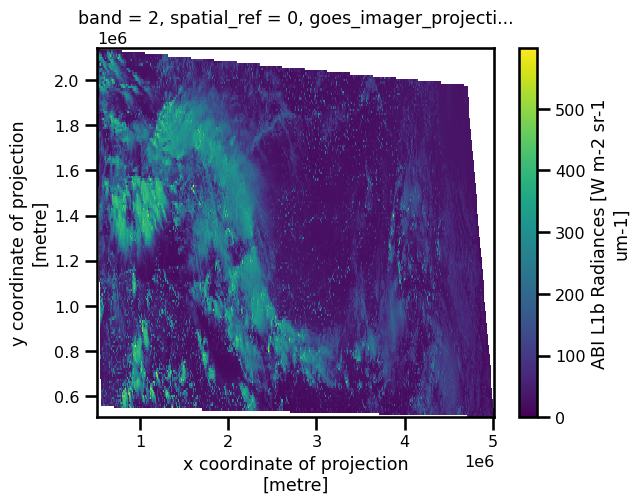

In [20]:
ds_goes_reproject.radiance.isel(band=1).plot(cmap="viridis", vmin=0.0)

## Example - Country Polygon

In [21]:
from odc.geo.data import ocean_geom, country_geom

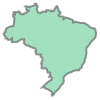

In [22]:
brazil_country_geom = country_geom(iso3="BRA")
brazil_country_geom

In [23]:
type(brazil_country_geom)

odc.geo.geom.Geometry

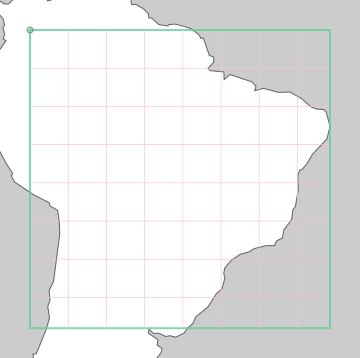

In [24]:
# create a geobox
gbox = GeoBox.from_geopolygon(brazil_country_geom, resolution=0.01, crs=brazil_country_geom.crs)
gbox

In [ ]:
%%time

ds = geoprocess_goes16_file(
    set_goes_files,
    resolution=10_000, 
    geometry=gbox,
    method="polygon",
)

Loading Radiance file 1/16: OR_ABI-L1b-RadF-M6C01_G16_s20202751820193_e20202751829501_c20202751829557.nc:   6%|███████                                                                                                          | 1/16 [00:25<06:22, 25.48s/it]

In [23]:
%%time
from odc.geo.crs import CRS

dst_crs = CRS("EPSG:4326")
geometries = [gbox.boundingbox.polygon]
ds_goes_reproject = ds.rio.clip(geometries=geometries, crs=dst_crs)

CPU times: user 156 ms, sys: 25.8 ms, total: 182 ms
Wall time: 182 ms


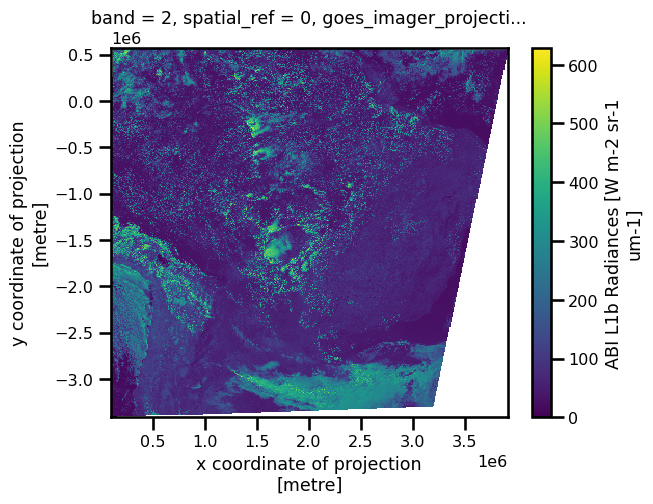

In [25]:
ds_goes_reproject.radiance.isel(band=1).plot(cmap="viridis", vmin=0.0)

### Example: MODIS

In [26]:
# list of all .hdf files in the directory
modis_read_dir = Path("/pool/usuarios/juanjohn/data/iti/pipeline_test/modis/clean")
all_modis_files = get_list_filenames(modis_read_dir, ".nc")

len(all_modis_files)

12

In [27]:
from rs_tools._src.geoprocessing.modis.geoprocessor_modis_refactor import regrid_to_regular
# load MODIS
ds_modis = xr.open_dataset(all_modis_files[0])

# regrid to regular grid
# preserve coordinates
band_wavelength = ds_modis.band_wavelength
time = ds_modis.time
ds_modis = regrid_to_regular(ds_modis["radiance"], resolution=0.05)
ds_modis["band_wavelength"] = band_wavelength
ds_modis["time"] = time
ds_modis

<xarray.Dataset> Size: 32MB
Dimensions:          (band: 38, latitude: 419, longitude: 497,
                      band_wavelength: 38, time: 1)
Coordinates: (6)
Data variables: (1)

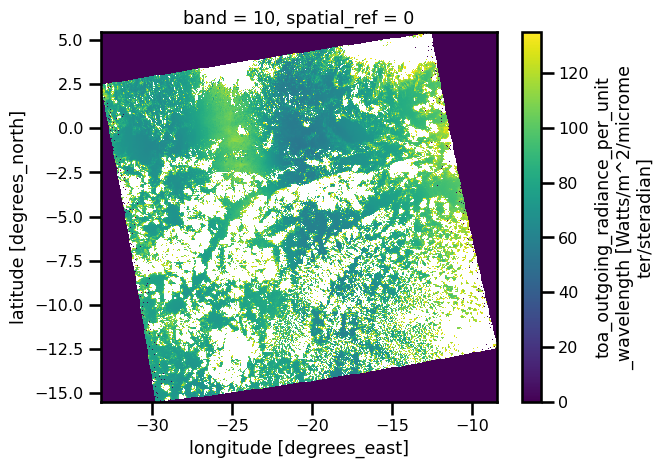

In [28]:
ds_modis.radiance.isel(band=1).plot(cmap="viridis", vmin=0.0)

In [29]:
ds_modis.rio.resolution()

(0.05, -0.05)

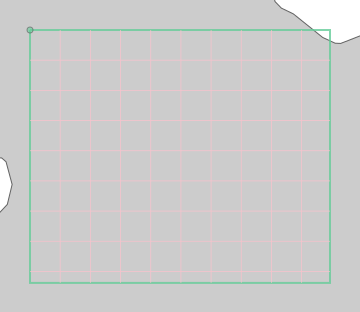

In [30]:
# initialize geobox
resolution = 0.25 # degrees
gbox = GeoBox.from_bbox(ds_modis.rio.bounds(), shape=ds_modis.rio.shape, crs=ds_modis.rio.crs)

gbox

In [31]:
dst_crs = CRS("EPSG:4326")
geometries = [gbox.boundingbox.polygon]
ds_goes_reproject = ds.rio.clip(geometries=geometries, crs=dst_crs)

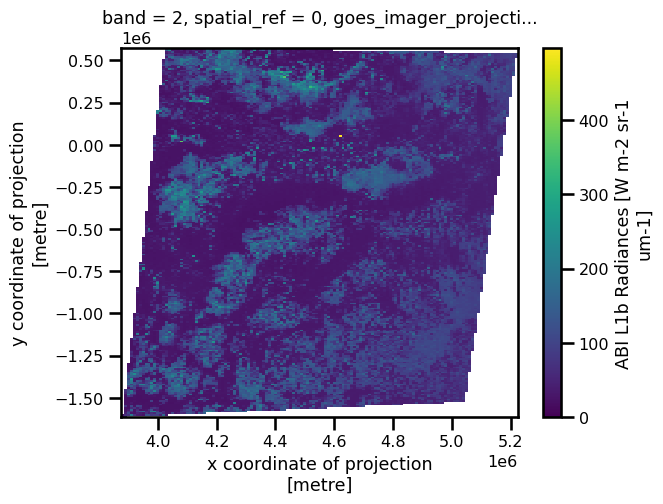

In [33]:
ds_goes_reproject.radiance.isel(band=1).plot(cmap="viridis", vmin=0.0)